In [1]:
# I will start by first loading the cleaned data

import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("listings_clean.csv")

df.head()

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,amenity_tv,amenity_washer,amenity_dryer,amenity_dishwasher,amenity_free_street_parking,amenity_private_entrance,amenity_dedicated_workspace,amenity_self_checkin,amenity_pets_allowed,amenity_bathtub
0,3781,4804,2008-12-03,"Massachusetts, United States",within a day,100.0,19.0,True,East Boston,3.0,...,True,True,True,True,True,False,False,False,False,False
1,5506,8229,2009-02-19,"Boston, MA",within an hour,100.0,100.0,True,Roxbury,12.0,...,True,True,True,False,True,True,False,True,False,True
2,6695,8229,2009-02-19,"Boston, MA",within an hour,100.0,100.0,True,Roxbury,12.0,...,True,True,True,True,True,False,False,True,False,False
3,8789,26988,2009-07-22,"Boston, MA",within a few hours,100.0,37.0,True,Beacon Hill,8.0,...,True,True,True,False,False,False,False,False,False,True
4,10811,38997,2009-09-16,NaN,within a few hours,94.0,59.0,False,Back Bay,21.0,...,True,False,True,False,False,False,False,False,True,False


In [2]:
# Now I will define feature matrix and target variable

# Target variable
y = df["price"]

# Feature matrix (all other columns except price)
X = df.drop(columns=["price"])

X.shape, y.shape


((3506, 77), (3506,))

In [3]:
# I will now perform a 80-20 split (80% training, 20% testing)

from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% for test
    random_state=42,    
    shuffle=True        
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2804, 77), (702, 77), (2804,), (702,))

In [5]:
# I will now identify numeric vs. categorial columns

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 47
Categorical features: 30


In [11]:
# Now I will define the preprocessing pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numeric: impute missing with median, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute missing with "Missing", then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [12]:
# I will now define three models 

# The models we are using are: Linear Regression, Random Forest, and Gradient Boosting

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Baseline linear model
lin_reg = LinearRegression()

# Random Forest
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Gradient Boosting
gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [13]:
# Can now wrap each model with the pipeline

from sklearn.pipeline import Pipeline

models = {
    "Linear Regression": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", lin_reg)
    ]),
    "Random Forest": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", rf_reg)
    ]),
    "Gradient Boosting": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", gb_reg)
    ]),
}

In [15]:
# Now I will train and evaluate all the models and compute MAE, RMSE, and R^2

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results).set_index("Model")
results_df

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...


,MAE,RMSE,R2
Model,,,
Linear Regression,971.713998,2046.700213,0.809207
Random Forest,71.395071,302.860875,0.995822
Gradient Boosting,74.705954,284.976230,0.996301


In [16]:
# Look for columns whose names suggest they use price or revenue
suspicious_keywords = ["price", "revenue", "income", "earnings"]
suspicious_cols = [col for col in X.columns 
                   if any(kw in col.lower() for kw in suspicious_keywords)]

suspicious_cols

['estimated_revenue_l365d']

In [17]:
import numpy as np

# Select only numeric columns, including price
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Correlation of each numeric feature with price
corr_with_price = df[numeric_cols].corr()["price"].drop("price").sort_values(ascending=False)

corr_with_price.head(20)

estimated_revenue_l365d      0.406966
host_total_listings_count    0.282461
host_id                      0.193439
accommodates                 0.149618
host_listings_count          0.134423
maximum_nights               0.123481
bathrooms                    0.109681
availability_60              0.104552
availability_30              0.102668
id                           0.101054
availability_90              0.098495
availability_eoy             0.096857
availability_365             0.081072
beds                         0.077857
longitude                    0.059468
bedrooms                     0.046846
review_scores_location       0.041168
host_response_rate           0.030254
review_scores_cleanliness    0.023263
latitude                     0.019307
Name: price, dtype: float64

In [18]:
# 1. Drop target and leaky revenue column
leaky_cols = ["estimated_revenue_l365d"]

X = df.drop(columns=["price"] + leaky_cols)
y = df["price"]

# 2. Re-split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 3. Rebuild feature lists
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

models = {
    "Linear Regression": Pipeline(steps=[("preprocessor", preprocessor), ("model", lin_reg)]),
    "Random Forest": Pipeline(steps=[("preprocessor", preprocessor), ("model", rf_reg)]),
    "Gradient Boosting": Pipeline(steps=[("preprocessor", preprocessor), ("model", gb_reg)]),
}

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results).set_index("Model")
results_df

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...


,MAE,RMSE,R2
Model,,,
Linear Regression,956.285735,2031.574536,0.812016
Random Forest,83.229701,368.935242,0.993801
Gradient Boosting,84.254295,374.757314,0.993603


In [21]:
# Hyerparamter tuning for Random Forest

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform  

rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_param_distributions = {
    "model__n_estimators": randint(100, 600),   
    "model__max_depth": randint(3, 25),           
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["auto", "sqrt", 0.3, 0.5, 0.8],
    "model__bootstrap": [True, False],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_distributions,
    n_iter=40,  
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best RF CV MAE:", -rf_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklear

Best RF params: {'model__bootstrap': False, 'model__max_depth': 24, 'model__max_features': 0.8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 502}
Best RF CV MAE: 102.99324383171299
[CV] END model__bootstrap=True, model__max_depth=22, model__max_features=0.8, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221; total time=  32.4s
[CV] END model__bootstrap=True, model__max_depth=13, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=459; total time=  25.4s
[CV] END model__bootstrap=True, model__max_depth=13, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=459; total time=  27.4s
[CV] END model__bootstrap=False, model__max_depth=5, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=13, model__n_estimators=513; total time=  22.9s
[CV] END model__bootstrap=False, model__max_depth=4, model__max_feature

[CV] END model__bootstrap=True, model__max_depth=22, model__max_features=0.8, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221; total time=  32.2s
[CV] END model__bootstrap=True, model__max_depth=22, model__max_features=0.8, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221; total time=  30.3s
[CV] END model__bootstrap=False, model__max_depth=5, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=13, model__n_estimators=513; total time=  21.8s
[CV] END model__bootstrap=False, model__max_depth=5, model__max_features=0.8, model__min_samples_leaf=2, model__min_samples_split=13, model__n_estimators=513; total time=  22.4s
[CV] END model__bootstrap=False, model__max_depth=4, model__max_features=0.5, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559; total time=  12.9s
[CV] END model__bootstrap=False, model__max_depth=24, model__max_features=0.8, model__min_samples_leaf=9, model__

[CV] END model__bootstrap=True, model__max_depth=22, model__max_features=0.8, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221; total time=  32.4s
[CV] END model__bootstrap=True, model__max_depth=13, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=459; total time=  25.6s
[CV] END model__bootstrap=True, model__max_depth=13, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=459; total time=  27.3s
[CV] END model__bootstrap=False, model__max_depth=4, model__max_features=0.5, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559; total time=  14.2s
[CV] END model__bootstrap=False, model__max_depth=4, model__max_features=0.5, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559; total time=  13.3s
[CV] END model__bootstrap=False, model__max_depth=24, model__max_features=0.8, model__min_samples_leaf=9, model__mi

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_best = rf_search.best_estimator_

y_pred_rf = rf_best.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Tuned Random Forest - Test MAE:", rf_mae)
print("Tuned Random Forest - Test RMSE:", rf_rmse)
print("Tuned Random Forest - Test R2:", rf_r2)


Tuned Random Forest - Test MAE: 73.42041670896234
Tuned Random Forest - Test RMSE: 307.988141548086
Tuned Random Forest - Test R2: 0.9956796144242702


In [23]:
# Hyperparameter Tuning for Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor

gb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_param_distributions = {
    "model__n_estimators": randint(100, 600),
    "model__learning_rate": uniform(0.01, 0.3),   # ~0.01 to 0.31
    "model__max_depth": randint(2, 8),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__subsample": uniform(0.5, 0.5),        # 0.5–1.0
    "model__max_features": ["auto", "sqrt", 0.3, 0.5, 0.8],
}

gb_search = RandomizedSearchCV(
    gb_pipe,
    param_distributions=gb_param_distributions,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

gb_search.fit(X_train, y_train)

print("Best GB params:", gb_search.best_params_)
print("Best GB CV MAE:", -gb_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
65 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/skumar010/anaconda3/envs/newsapi38/lib/python3.10/site-packages/sklear

Best GB params: {'model__learning_rate': 0.1150235223084027, 'model__max_depth': 2, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__n_estimators': 416, 'model__subsample': 0.7495966899423762}
Best GB CV MAE: 133.41480156603637


In [24]:
gb_best = gb_search.best_estimator_

y_pred_gb = gb_best.predict(X_test)

gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, y_pred_gb)

print("Tuned Gradient Boosting - Test MAE:", gb_mae)
print("Tuned Gradient Boosting - Test RMSE:", gb_rmse)
print("Tuned Gradient Boosting - Test R2:", gb_r2)

Tuned Gradient Boosting - Test MAE: 86.34922513706901
Tuned Gradient Boosting - Test RMSE: 280.16038152687327
Tuned Gradient Boosting - Test R2: 0.9964250665839447


In [25]:
results_tuned = [
    {
        "Model": "Random Forest (tuned)",
        "MAE": rf_mae,
        "RMSE": rf_rmse,
        "R2": rf_r2
    },
    {
        "Model": "Gradient Boosting (tuned)",
        "MAE": gb_mae,
        "RMSE": gb_rmse,
        "R2": gb_r2
    }
]

pd.DataFrame(results_tuned).set_index("Model")

,MAE,RMSE,R2
Model,,,
Random Forest (tuned),73.420417,307.988142,0.995680
Gradient Boosting (tuned),86.349225,280.160382,0.996425


[CV] END model__learning_rate=0.12236203565420874, model__max_depth=6, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221, model__subsample=0.5779972601681014; total time=   4.4s
[CV] END model__learning_rate=0.027425083650459835, model__max_depth=6, model__max_features=0.5, model__min_samples_leaf=8, model__min_samples_split=4, model__n_estimators=249, model__subsample=0.5282057895135501; total time=   8.3s
[CV] END model__learning_rate=0.22659963168004743, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559, model__subsample=0.8058265802441404; total time=   2.4s
[CV] END model__learning_rate=0.22659963168004743, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559, model__subsample=0.8058265802441404; total time=   2.2s
[CV] END model__learning_rate=0.012119891565915222, model__max_depth=

[CV] END model__learning_rate=0.12236203565420874, model__max_depth=6, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221, model__subsample=0.5779972601681014; total time=   4.3s
[CV] END model__learning_rate=0.12236203565420874, model__max_depth=6, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221, model__subsample=0.5779972601681014; total time=   5.5s
[CV] END model__learning_rate=0.027425083650459835, model__max_depth=6, model__max_features=0.5, model__min_samples_leaf=8, model__min_samples_split=4, model__n_estimators=249, model__subsample=0.5282057895135501; total time=   6.9s
[CV] END model__learning_rate=0.22659963168004743, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559, model__subsample=0.8058265802441404; total time=   1.7s
[CV] END model__learning_rate=0.012119891565915222, model__max_depth=2

[CV] END model__learning_rate=0.12236203565420874, model__max_depth=6, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221, model__subsample=0.5779972601681014; total time=   4.3s
[CV] END model__learning_rate=0.027425083650459835, model__max_depth=6, model__max_features=0.5, model__min_samples_leaf=8, model__min_samples_split=4, model__n_estimators=249, model__subsample=0.5282057895135501; total time=   8.3s
[CV] END model__learning_rate=0.027425083650459835, model__max_depth=6, model__max_features=0.5, model__min_samples_leaf=8, model__min_samples_split=4, model__n_estimators=249, model__subsample=0.5282057895135501; total time=   5.9s
[CV] END model__learning_rate=0.012119891565915222, model__max_depth=2, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=13, model__n_estimators=154, model__subsample=0.9916154429033941; total time=   0.1s
[CV] END model__learning_rate=0.150028867974394, model__max_depth=6

[CV] END model__learning_rate=0.12236203565420874, model__max_depth=6, model__max_features=0.3, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221, model__subsample=0.5779972601681014; total time=   4.4s
[CV] END model__learning_rate=0.027425083650459835, model__max_depth=6, model__max_features=0.5, model__min_samples_leaf=8, model__min_samples_split=4, model__n_estimators=249, model__subsample=0.5282057895135501; total time=   8.4s
[CV] END model__learning_rate=0.22659963168004743, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559, model__subsample=0.8058265802441404; total time=   2.4s
[CV] END model__learning_rate=0.22659963168004743, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=559, model__subsample=0.8058265802441404; total time=   2.2s
[CV] END model__learning_rate=0.012119891565915222, model__max_depth=

In [26]:
import joblib

# Best tuned Random Forest pipeline (includes preprocessor + model)
rf_best = rf_search.best_estimator_

# Save model
joblib.dump(rf_best, "airbnb_rf_model.joblib")

# Save list of input feature names (original columns)
joblib.dump(X_train.columns.tolist(), "model_features.joblib")

['model_features.joblib']

In [28]:
import pandas as pd

# Combine features + target for training set
train_df = X_train.copy()
train_df["price"] = y_train

# Combine features + target for test set
test_df = X_test.copy()
test_df["price"] = y_test

# (Optional) reset index so rows are 0..n-1 in each file
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save to CSV
train_df.to_csv("listings_train_80.csv", index=False)
test_df.to_csv("listings_test_20.csv", index=False)


In [61]:
rf_best = rf_search.best_estimator_

y_pred_test = rf_best.predict(X_test)


results = X_test.copy()


results["true_price"] = y_test.values
results["pred_price"] = y_pred_test
results["abs_error"] = (results["true_price"] - results["pred_price"]).abs()


if "id" in results.columns:
    id_col = "id"
elif "listing_id" in results.columns:
    id_col = "listing_id"
else:
    id_col = "row_index"
    results[id_col] = results.index

cols_to_show = [id_col, "true_price", "pred_price", "abs_error"]

top10_accurate = results.sort_values("abs_error", ascending=True).head(10)[cols_to_show]

print("Top 10 most accurate predictions (by absolute error):")
print(top10_accurate.to_string(index=False))


Top 10 most accurate predictions (by absolute error):
                 id  true_price   pred_price  abs_error
1145757720673204162     50000.0 50000.000000   0.000000
1145756656258071731     40000.0 40000.000000   0.000000
1467394364147035274     50000.0 50000.000000   0.000000
1500952811136547098      1070.0  1070.000000   0.000000
1467394359101671929     50000.0 50000.000000   0.000000
1145759772640686004     40000.0 40000.000000   0.000000
 914457661179942537       170.0   170.053159   0.053159
1490652888318549377       103.0   103.056372   0.056372
 985499257021530456       110.0   109.870295   0.129705
 791467696621552585       125.0   124.867376   0.132624


In [62]:

if "id" in results.columns:
    id_col = "id"
elif "listing_id" in results.columns:
    id_col = "listing_id"
else:
    id_col = "row_index"
    if "row_index" not in results.columns:
        results[id_col] = results.index

cols_to_show = [id_col, "true_price", "pred_price", "abs_error"]

top10_worst = results.sort_values("abs_error", ascending=False).head(10)[cols_to_show]

print("Top 10 worst predictions (by absolute error):")
print(top10_worst.to_string(index=False))

Top 10 worst predictions (by absolute error):
                 id  true_price   pred_price   abs_error
1145753293926550841     50000.0 43187.250996 6812.749004
           31591262       338.0  2475.611554 2137.611554
1193457837974640772     50000.0 48027.888446 1972.111554
1067563969205970886      1900.0   549.938911 1350.061089
1415541106677937744      1288.0   102.545589 1185.454411
 793442721651271774      1614.0   576.013147 1037.986853
           43977877       170.0  1084.214796  914.214796
            4119345       241.0   948.030129  707.030129
           11521541      1288.0   618.890505  669.109495
           14704252       946.0   306.189952  639.810048


In [38]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_baseline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])


rf_baseline.fit(X_train, y_train)
y_pred_base = rf_baseline.predict(X_test)

base_mae = mean_absolute_error(y_test, y_pred_base)
base_mse = mean_squared_error(y_test, y_pred_base)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred_base)

print("Baseline RF:")
print("  MAE :", base_mae)
print("  RMSE:", base_rmse)
print("  R²  :", base_r2)

rf_tuned = rf_search.best_estimator_
y_pred_tuned = rf_tuned.predict(X_test)

tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_mse = mean_squared_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(tuned_mse)
tuned_r2 = r2_score(y_test, y_pred_tuned)

print("\nTuned RF:")
print("  MAE :", tuned_mae)
print("  RMSE:", tuned_rmse)
print("  R²  :", tuned_r2)

rf_results = pd.DataFrame({
    "Model": ["Random Forest (baseline)", "Random Forest (tuned)"],
    "MAE": [base_mae, tuned_mae],
    "RMSE": [base_rmse, tuned_rmse],
    "R2": [base_r2, tuned_r2]
})

rf_results


Baseline RF:
  MAE : 83.22970085470085
  RMSE: 368.9352419112944
  R²  : 0.9938005265854192

Tuned RF:
  MAE : 73.42041670896234
  RMSE: 307.988141548086
  R²  : 0.9956796144242702


,Model,MAE,RMSE,R2
0,Random Forest (baseline),83.229701,368.935242,0.993801
1,Random Forest (tuned),73.420417,307.988142,0.995680


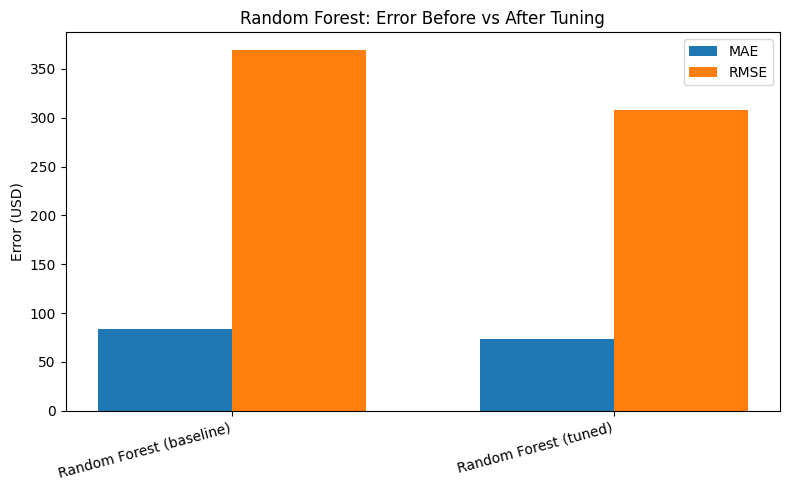

In [39]:
import matplotlib.pyplot as plt
import numpy as np

models = rf_results["Model"].values
mae_vals = rf_results["MAE"].values
rmse_vals = rf_results["RMSE"].values

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, mae_vals, width, label="MAE")
ax.bar(x + width/2, rmse_vals, width, label="RMSE")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha="right")
ax.set_ylabel("Error (USD)")
ax.set_title("Random Forest: Error Before vs After Tuning")
ax.legend()
plt.tight_layout()

plt.show()

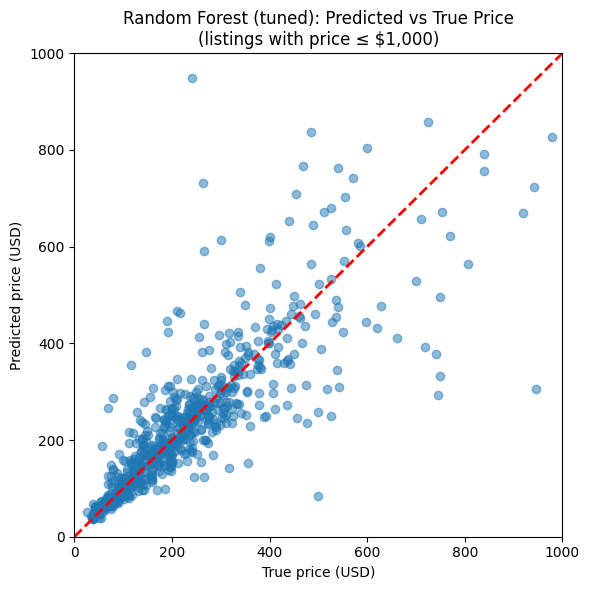

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


y_pred_tuned_s = pd.Series(y_pred_tuned, index=y_test.index)

threshold = 1000
mask = y_test <= threshold
y_true_inliers = y_test[mask]
y_pred_inliers = y_pred_tuned_s[mask]

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_true_inliers, y_pred_inliers, alpha=0.5)

ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

ax.plot([0, 1000], [0, 1000], "r--", linewidth=2)

ax.set_xlabel("True price (USD)")
ax.set_ylabel("Predicted price (USD)")
ax.set_title("Random Forest (tuned): Predicted vs True Price\n(listings with price ≤ $1,000)")
plt.tight_layout()

plt.show()


In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

gb_baseline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(
        random_state=42
    ))
])

gb_baseline.fit(X_train, y_train)
y_pred_gb_base = gb_baseline.predict(X_test)

gb_base_mae = mean_absolute_error(y_test, y_pred_gb_base)
gb_base_mse = mean_squared_error(y_test, y_pred_gb_base)
gb_base_rmse = np.sqrt(gb_base_mse)
gb_base_r2 = r2_score(y_test, y_pred_gb_base)

print("Baseline Gradient Boosting:")
print("  MAE :", gb_base_mae)
print("  RMSE:", gb_base_rmse)
print("  R²  :", gb_base_r2)

gb_tuned = gb_search.best_estimator_
y_pred_gb_tuned = gb_tuned.predict(X_test)

gb_tuned_mae = mean_absolute_error(y_test, y_pred_gb_tuned)
gb_tuned_mse = mean_squared_error(y_test, y_pred_gb_tuned)
gb_tuned_rmse = np.sqrt(gb_tuned_mse)
gb_tuned_r2 = r2_score(y_test, y_pred_gb_tuned)

print("\nTuned Gradient Boosting:")
print("  MAE :", gb_tuned_mae)
print("  RMSE:", gb_tuned_rmse)
print("  R²  :", gb_tuned_r2)

gb_results = pd.DataFrame({
    "Model": ["Gradient Boosting (baseline)", "Gradient Boosting (tuned)"],
    "MAE": [gb_base_mae, gb_tuned_mae],
    "RMSE": [gb_base_rmse, gb_tuned_rmse],
    "R2": [gb_base_r2, gb_tuned_r2]
})

gb_results

Baseline Gradient Boosting:
  MAE : 92.23732347471177
  RMSE: 381.65187707078763
  R²  : 0.9933657883525709

Tuned Gradient Boosting:
  MAE : 86.34922513706901
  RMSE: 280.16038152687327
  R²  : 0.9964250665839447


,Model,MAE,RMSE,R2
0,Gradient Boosting (baseline),92.237323,381.651877,0.993366
1,Gradient Boosting (tuned),86.349225,280.160382,0.996425


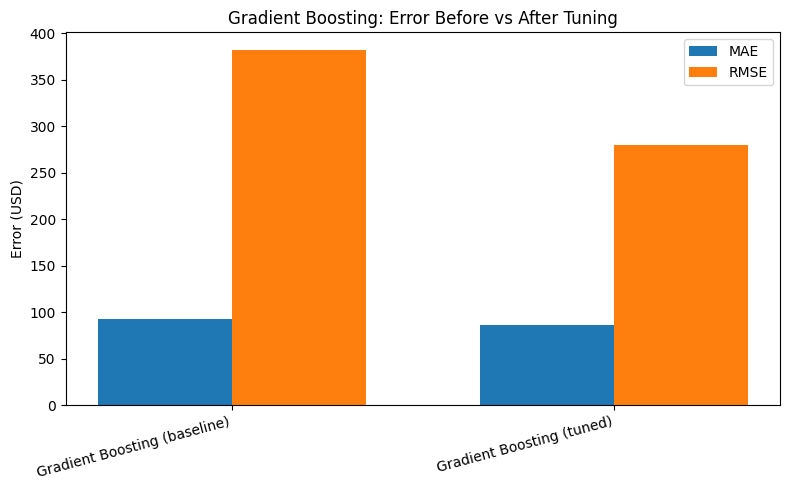

In [48]:
import matplotlib.pyplot as plt
import numpy as np

models = gb_results["Model"].values
mae_vals = gb_results["MAE"].values
rmse_vals = gb_results["RMSE"].values

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, mae_vals, width, label="MAE")
ax.bar(x + width/2, rmse_vals, width, label="RMSE")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha="right")
ax.set_ylabel("Error (USD)")
ax.set_title("Gradient Boosting: Error Before vs After Tuning")
ax.legend()
plt.tight_layout()

plt.show()

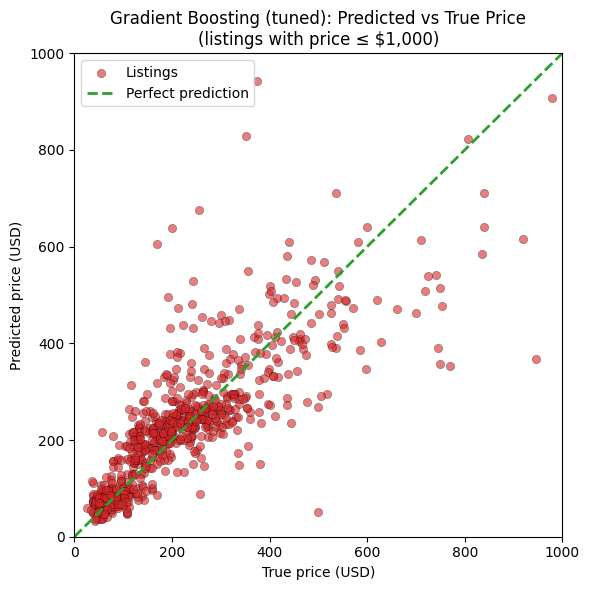

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

y_pred_gb_tuned_s = pd.Series(y_pred_gb_tuned, index=y_test.index)

threshold = 1000
mask = y_test <= threshold
y_true_inliers_gb = y_test[mask]
y_pred_inliers_gb = y_pred_gb_tuned_s[mask]

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    y_true_inliers_gb,
    y_pred_inliers_gb,
    alpha=0.6,
    color="tab:red",
    edgecolors="k",
    linewidths=0.3,
    label="Listings"
)


ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)


ax.plot(
    [0, 1000],
    [0, 1000],
    color="tab:green",
    linestyle="--",
    linewidth=2,
    label="Perfect prediction"
)

ax.set_xlabel("True price (USD)")
ax.set_ylabel("Predicted price (USD)")
ax.set_title("Gradient Boosting (tuned): Predicted vs True Price\n(listings with price ≤ $1,000)")
ax.legend()
plt.tight_layout()

plt.show()


In [55]:
import numpy as np
import pandas as pd

rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)

results = X_test.copy()
results["true_price"] = y_test.values
results["pred_price"] = y_pred_rf
results["abs_error"] = (results["true_price"] - results["pred_price"]).abs()


if "id" in results.columns:
    id_col = "id"
elif "listing_id" in results.columns:
    id_col = "listing_id"
else:
    id_col = "row_index"
    results[id_col] = results.index

top10_best = results.sort_values("abs_error", ascending=True).head(10)

top10_worst = results.sort_values("abs_error", ascending=False).head(10)

top10_best_simple = top10_best[[id_col, "true_price", "pred_price", "abs_error"]]
top10_worst_simple = top10_worst[[id_col, "true_price", "pred_price", "abs_error"]]

top10_best_simple, top10_worst_simple

(                       id  true_price    pred_price  abs_error
 2483  1145757720673204162     50000.0  50000.000000   0.000000
 2481  1145756656258071731     40000.0  40000.000000   0.000000
 3334  1467394364147035274     50000.0  50000.000000   0.000000
 3438  1500952811136547098      1070.0   1070.000000   0.000000
 3331  1467394359101671929     50000.0  50000.000000   0.000000
 2488  1145759772640686004     40000.0  40000.000000   0.000000
 1894   914457661179942537       170.0    170.053159   0.053159
 3390  1490652888318549377       103.0    103.056372   0.056372
 2107   985499257021530456       110.0    109.870295   0.129705
 1725   791467696621552585       125.0    124.867376   0.132624,
                        id  true_price    pred_price    abs_error
 2476  1145753293926550841     50000.0  43187.250996  6812.749004
 679              31591262       338.0   2475.611554  2137.611554
 2589  1193457837974640772     50000.0  48027.888446  1972.111554
 2325  1067563969205970886     

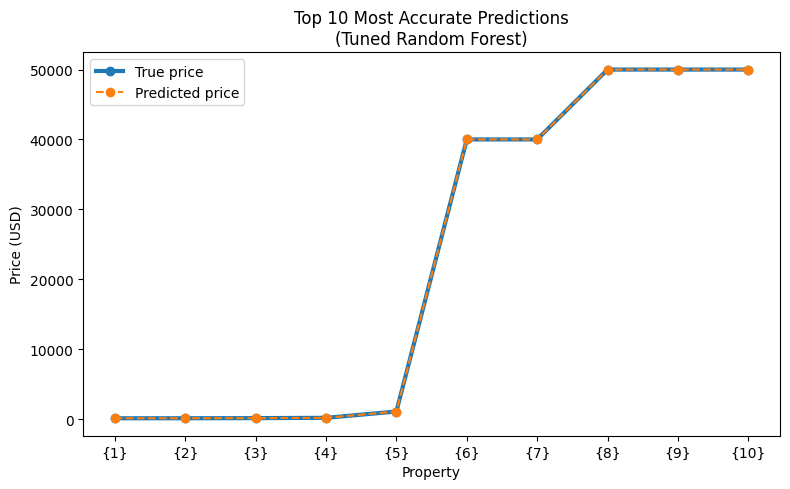

In [66]:
import numpy as np
import matplotlib.pyplot as plt


top10_best_sorted = top10_best.sort_values("true_price")

x_best = np.arange(1, len(top10_best_sorted) + 1)

best_true = top10_best_sorted["true_price"].values
best_pred = top10_best_sorted["pred_price"].values

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(
    x_best,
    best_true,
    marker="o",
    linestyle="-",
    color="tab:blue",
    linewidth=3, 
    label="True price"
)

ax.plot(
    x_best,
    best_pred,
    marker="o",
    linestyle="--",
    color="tab:orange",
    label="Predicted price"
)

ax.set_xticks(x_best)
ax.set_xticklabels([{i} for i in x_best])

ax.set_xlabel("Property")
ax.set_ylabel("Price (USD)")
ax.set_title("Top 10 Most Accurate Predictions\n(Tuned Random Forest)")
ax.legend()
plt.tight_layout()
plt.show()
